# Analysis for figure S1

In [38]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import sys
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy

import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb
from lightgbm import LGBMClassifier
import re

from sklearn.ensemble import GradientBoostingClassifier


warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append(os.path.abspath('../..'))

import analysis.calc_single_cell_properties as calculator 
import analysis.calc_auc_over_time as auc_calculator 
import analysis.utils as utils
import data_layer.utils as data_utils
from model_layer import build_model
from model_layer import utils as model_utils
from configuration import consts, params

In [26]:
def load_data_(modality, con_train_n, diff_train_n, con_test_n, diff_test_n, load_raw_test_data=False):
    model_path = consts.intensity_model_path if modality == "actin_intensity" else consts.motility_model_path
    _, X_train, X_test, y_train, y_test = data_utils.load_data(model_path % (1,5), load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
    X_train = X_train.drop(columns=["Spot track ID"])
    X_test = X_test.drop(columns=["Spot track ID"])

    y_train = y_train["target"]
    y_test = y_test["target"]
    
    con_df_test, diff_df_test = None, None
    if load_raw_test_data:
        diff_df_train, con_df_train, con_df_test, diff_df_test = build_model.get_to_run(transformed_data_path=consts.transformed_data_path, modality=modality,
                                                           con_train_num=con_train_n, diff_train_num=diff_train_n,
                                                           con_test_num=con_test_n, diff_test_num=diff_test_n)
        
        
    return (X_train, y_train, X_test, y_test), (con_df_test, diff_df_test)

In [5]:
from sklearn.model_selection import train_test_split
path = consts.storage_path + "15-12-2022-motility local dens-False, s1, s5 train [130, 160] diff window/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
_, X_train, X_test, y_train, y_test = data_utils.load_data(path, load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)

In [6]:
y_train["target"].value_counts(), y_test["target"].value_counts()

(False    468
 True     268
 Name: target, dtype: int64,
 True     577
 False    180
 Name: target, dtype: int64)

In [7]:
def evaluate_clf(model, test_features, test_labels):
    predictions = model.predict(test_features)
    probs = model.predict_proba(test_features)[:, 1]
    correct_predictions = np.sum(predictions == test_labels)
    accuracy = correct_predictions / len(test_labels)
    
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    auc_score = metrics.auc(fpr, tpr)
    brier = metrics.brier_score_loss(test_labels, probs)  
    return auc_score, brier

# classifiers comparison

In [8]:
con_train_n = 1
diff_train_n = 5
con_test_n = 2
diff_test_n = 3
modality="motility"

In [9]:
from tsfresh import select_features
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

# prepare configuration for cross validation test harness
# prepare models
models = []
models.append(('RF', RandomForestClassifier))
models.append(('GB', GradientBoostingClassifier))
models.append(('LR', LogisticRegression))
models.append(('KNN', KNeighborsClassifier))
models.append(('SVM', SVC))


def clean_cols_drop_duplicates(df):
    df= df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_ ]+', '', x))
    df = df.loc[:,~df.columns.duplicated()]

    return df

def compare_algorithms(X_train, y_train, X_test, y_test, con_df_test, diff_df_test, modality):
    
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'roc_auc'
    for name, model_class in models:
        if name=="SVM":
            model = model_class(probability=True)
        else:
            model = model_class()
        model.fit(X_train, y_train)
        auc_score, _ = evaluate_clf(model, X_test, y_test)
        
        if name=="SVM":
            model_flip = model_class(probability=True)
        else:
            model_flip = model_class()
        model_flip.fit(X_test, y_test)
        auc_score_flip, _ = evaluate_clf(model_flip, X_train, y_train)
        
        results.append([auc_score, auc_score_flip])
        names.append(name)
        
        msg = "%s:test scores = %.3f +- (%.3f)" % (name, np.mean([auc_score,auc_score_flip]), np.std([auc_score,auc_score_flip])) + f"aucs: {round(auc_score,4)} original, {round(auc_score_flip,4)} flipped"
        print(msg)
    
#     boxplot algorithm comparison - cross_validation
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.savefig(consts.storage_path + f"eps_figs/algorithm_comparison_{modality}.eps", format="eps")
    plt.show()

In [27]:
from sklearn.model_selection import train_test_split

con_train_n = 1
diff_train_n = 5
con_test_n = 2
diff_test_n = 3
modality="motility"

path = consts.storage_path + "15-12-2022-motility local dens-False, s1, s5 train [130, 160] diff window/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
(X_train, y_train, X_test, y_test), (con_df_test, diff_df_test) = load_data_(modality, con_train_n, diff_train_n, con_test_n, diff_test_n, load_raw_test_data=True)


read data from video number 5
diff train len: (95638, 1580)
read data from video number 1
con_df_train len: (66544, 1580)
read data from video number 2
read data from video number 3


In [33]:
from sklearn.model_selection import train_test_split

con_train_n = 1
diff_train_n = 5
con_test_n = 2
diff_test_n = 3
modality="motility"

path = consts.storage_path + "15-12-2022-motility local dens-False, s1, s5 train [130, 160] diff window/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
(X_train, y_train, X_test, y_test), (con_df_test, diff_df_test) = load_data_(modality, con_train_n, diff_train_n, con_test_n, diff_test_n, load_raw_test_data=True)


read data from video number 5
diff train len: (95638, 1580)
read data from video number 1
con_df_train len: (66544, 1580)
read data from video number 2
read data from video number 3


In [47]:
_, X_train, X_test, y_train, y_test = data_utils.load_data(path, load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
dir_path = "outputs"
model_utils.train_model_compare_algorithms(X_train, y_train["target"], X_test, y_test["target"], dir_path)

              precision    recall  f1-score   support

       False       0.72      0.98      0.83       180
        True       0.99      0.88      0.93       577

    accuracy                           0.90       757
   macro avg       0.86      0.93      0.88       757
weighted avg       0.93      0.90      0.91       757

0.9290968611592529
classifier: RF, auc score: 0.9290968611592529
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       180
        True       1.00      1.00      1.00       577

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757

1.0
classifier: GB, auc score: 1.0
              precision    recall  f1-score   support

       False       0.77      1.00      0.87       180
        True       1.00      0.91      0.95       577

    accuracy                           0.93       757
   macro avg       0.88     

actin [0.78, 0.77, 0.76, 0.59, 0.54]
motility [0.8, 0.8, 0.64, 0.59, 0.59]


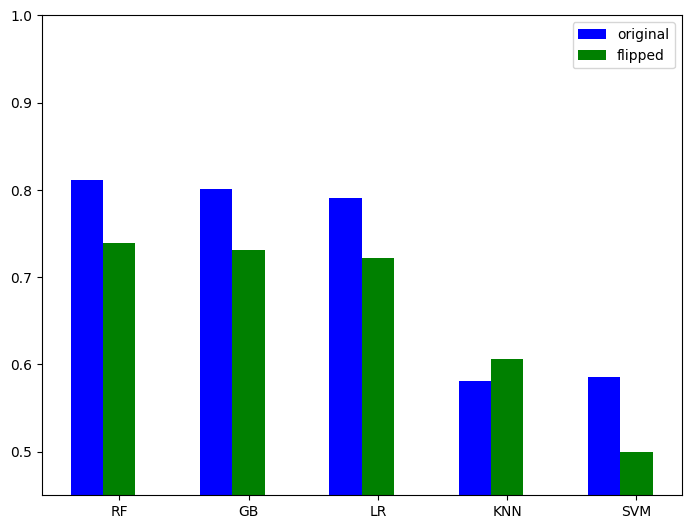

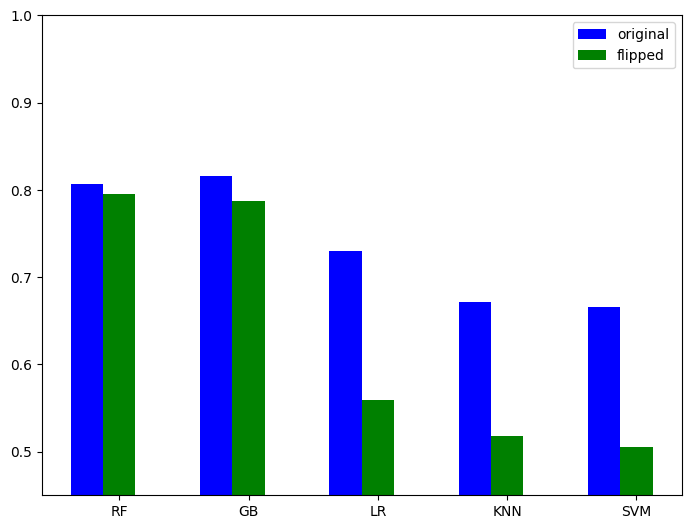

In [37]:
# actin intensity
names = ["RF", "GB", "LR", "KNN", "SVM"]
aucs_original = [0.8114577315617176, 0.8008809936452917, 0.7904823801270942, 0.5811910263816675, 0.5858463316002311]
aucs_flipped = [0.7390986245244366, 0.7311603745976003, 0.721543426657562, 0.605701069814327, 0.5]
mean_aucs = [round(val, 2) for val in np.mean([aucs_original, aucs_flipped], axis=0)]
print("actin", mean_aucs)

X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, aucs_original, color = 'b', width = 0.25, tick_label=names, label="original")
ax.bar(X + 0.25, aucs_flipped, color = 'g', width = 0.25, tick_label=names, label="flipped")
plt.ylim((0.45, 1))
plt.savefig(consts.storage_path + f"eps_figs/algorithm_comparison_intensity barplot.eps", format="eps")
plt.legend()

# motility
names = ["RF", "GB", "LR", "KNN", "SVM"]
aucs_original = [0.8068650105911805, 0.8162189485846331, 0.7303822453302523, 0.6715386096668592, 0.6657471596379743]##[0.8033988060851146, 0.8117080685538225, 0.7258713652994415, 0.6715386096668592, 0.6657471596379743]]
aucs_flipped = [0.7949036866947314, 0.7866277586426841, 0.5595898711570353, 0.5179550963133053, 0.5053418803418803]##[0.7900880214313051, 0.7898328868478122, 0.5595898711570353, 0.5179550963133053, 0.5053418803418803]]
print("motility", [round(val, 2) for val in  np.mean([aucs_original, aucs_flipped], axis=0)])
X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, aucs_original, color = 'b', width = 0.25, tick_label=names, label="original")
ax.bar(X + 0.25, aucs_flipped, color = 'g', width = 0.25, tick_label=names, label="flipped")
plt.ylim((0.45, 1))
plt.savefig(consts.storage_path + f"eps_figs/algorithm_comparison_motility barplot.eps", format="eps")
plt.legend()
